In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Đặt style cho biểu đồ
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")


file_path = '../input/final-dataset/36ThanhHoa.csv' 
df = pd.read_csv(file_path)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Kích thước tập train: {train_df.shape}")
print(f"Kích thước tập test: {test_df.shape}")

display(train_df.head())



Kích thước tập train: (18240, 15)
Kích thước tập test: (4560, 15)


,long,lat,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,label
10804,105.908178,19.930051,642.0,566.0,828.5,761.0,1267.0,1974.0,2236.0,2254.5,2445.0,2498.0,2156.0,1266.0,grassland
19928,105.818800,19.985395,333.5,378.0,599.0,433.5,956.5,2006.0,2316.0,1910.0,2523.5,2667.5,1548.0,865.0,shrubland
19756,105.787245,19.543405,413.0,407.0,709.0,440.0,1101.5,2530.0,2907.0,2955.0,3149.5,2896.5,1450.5,750.0,shrubland
3485,105.753935,19.405042,695.5,690.5,968.0,1159.0,1519.0,2117.0,2345.5,2328.5,2552.0,2476.0,2642.0,2043.0,barrenland
8197,105.741726,19.821393,222.0,283.0,463.0,276.0,662.0,1669.0,1989.0,2091.0,2170.0,2227.0,1056.0,487.0,forests


Số giá trị null trong mỗi cột:
long     0
lat      0
B1       0
B2       0
B3       0
B4       0
B5       0
B6       0
B7       0
B8       0
B8A      0
B9       0
B11      0
B12      0
label    0
dtype: int64

Số giá trị inf trong mỗi cột:
long    0
lat     0
B1      0
B2      0
B3      0
B4      0
B5      0
B6      0
B7      0
B8      0
B8A     0
B9      0
B11     0
B12     0
dtype: int64

Kích thước ban đầu của train_df: (18240, 15)
Kích thước sau khi loại bỏ null và inf: (18240, 15)
The number of label: 10


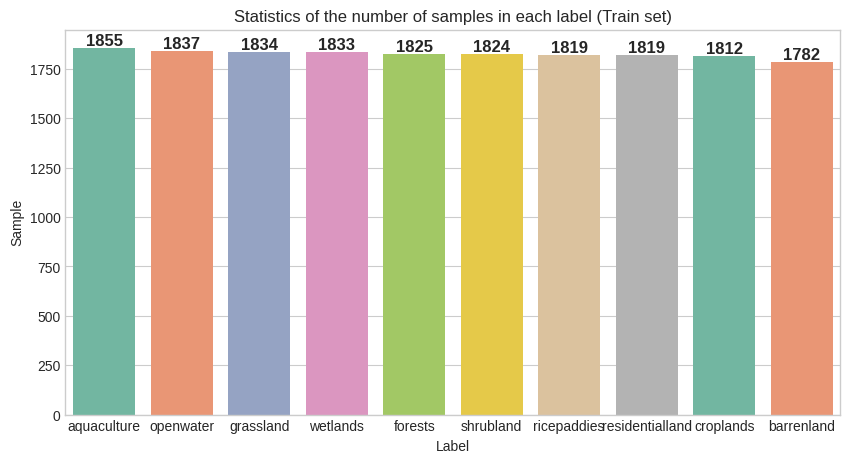

In [2]:
# Kiểm tra số lượng giá trị null và inf
print("Số giá trị null trong mỗi cột:")
print(train_df.isnull().sum())
print("\nSố giá trị inf trong mỗi cột:")
print(np.isinf(train_df.select_dtypes(include=[np.number])).sum())

# Loại bỏ các giá trị null và inf
train_df_clean = train_df.dropna()  # Loại bỏ các hàng chứa null
train_df_clean = train_df_clean[~train_df_clean.select_dtypes(include=[np.number]).isin([np.inf, -np.inf]).any(axis=1)]  # Loại bỏ các hàng chứa inf

print(f"\nKích thước ban đầu của train_df: {train_df.shape}")
print(f"Kích thước sau khi loại bỏ null và inf: {train_df_clean.shape}")

# Tính số lượng unique labels
num_unique_labels = train_df_clean['label'].nunique()
print(f"The number of label: {num_unique_labels}")

# Đếm số lượng mẫu trong mỗi label
label_counts = train_df_clean['label'].value_counts()

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")

# Ghi số lượng trên từng cột
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Label")
plt.ylabel("Sample")
plt.title("Statistics of the number of samples in each label (Train set)")
plt.show()

In [3]:
def encode_cat_cols(df, cat_cols):
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])
        # In ra các giá trị nhãn và số tương ứng
        print(f"Label encoding for {col}:")
        for label, num in zip(le.classes_, range(len(le.classes_))):
            print(f"{label} -> {num}")

# Giả sử df là dataframe của bạn với cột 'label'
print("Encode for Train")
encode_cat_cols(train_df, ['label'])

print("Encode for Test")
encode_cat_cols(test_df, ['label'])


Encode for Train
Label encoding for label:
aquaculture -> 0
barrenland -> 1
croplands -> 2
forests -> 3
grassland -> 4
openwater -> 5
residentialland -> 6
ricepaddies -> 7
shrubland -> 8
wetlands -> 9
Encode for Test
Label encoding for label:
aquaculture -> 0
barrenland -> 1
croplands -> 2
forests -> 3
grassland -> 4
openwater -> 5
residentialland -> 6
ricepaddies -> 7
shrubland -> 8
wetlands -> 9


# Bỏ các features không phù hợp trong phân biệt lớp phủ
* B9: Dùng để phát hiện hơi nước trong khí quyển
* B10: Nhạy cảm với mây cirrus
* Longtitude, Latitude


In [4]:
#Drop cols
columns_to_drop = ['B1','B9', 'B10','long', 'lat']

# Kiểm tra xem các cột có tồn tại trong DataFrame trước khi xóa
existing_columns = [col for col in columns_to_drop if col in train_df.columns]

# Xóa các cột đó
train_df = train_df.drop(columns=existing_columns)

# Chia dữ liệu các band cho 10000

In [5]:
# List of remaining Sentinel-2 band columns
band_columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

# Check which band columns exist in the DataFrame
existing_bands = [band for band in band_columns if band in train_df.columns]

if len(existing_bands) > 0:
    # Divide band values by 10000 to convert from integers to actual reflectance values (0-1)
    train_df[existing_bands] = train_df[existing_bands] / 10000.0
    
    # Check for anomalous values (if any)
    for band in existing_bands:
        # Ensure values are within reasonable range [0, 1]
        invalid_values = train_df[train_df[band] > 1.0].shape[0]
        if invalid_values > 0:
            print(f"Warning: Found {invalid_values} anomalous values (>1.0) in {band} after division by 10000")
    
    print(f"Successfully converted {existing_bands} bands to reflectance values (0-1) by dividing by 10000")
    
    # Display the first few rows to verify
    print("\nProcessed data sample:")
    display(train_df.head())
else:
    print("No Sentinel-2 band columns found in the dataset")


Successfully converted ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'] bands to reflectance values (0-1) by dividing by 10000

Processed data sample:


,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,label
10804,0.05660,0.08285,0.07610,0.12670,0.1974,0.22360,0.22545,0.24450,0.21560,0.1266,4
19928,0.03780,0.05990,0.04335,0.09565,0.2006,0.23160,0.19100,0.25235,0.15480,0.0865,8
19756,0.04070,0.07090,0.04400,0.11015,0.2530,0.29070,0.29550,0.31495,0.14505,0.0750,8
3485,0.06905,0.09680,0.11590,0.15190,0.2117,0.23455,0.23285,0.25520,0.26420,0.2043,1
8197,0.02830,0.04630,0.02760,0.06620,0.1669,0.19890,0.20910,0.21700,0.10560,0.0487,3


# Thêm các Features mới giúp phân biệt dễ hơn

In [6]:
# Tính toán các chỉ số
train_df['NDVI'] = (train_df['B8'] - train_df['B4']) / (train_df['B8'] + train_df['B4'])
train_df['NDWI'] = (train_df['B3'] - train_df['B8']) / (train_df['B3'] + train_df['B8'])
train_df['NDMI'] = (train_df['B8A'] - train_df['B11']) / (train_df['B8A'] + train_df['B11'])
train_df['NDBI'] = (train_df['B11'] - train_df['B8']) / (train_df['B11'] + train_df['B8'])
train_df['BSI'] = ((train_df['B12'] + train_df['B8']) - (train_df['B4'] + train_df['B3'])) / ((train_df['B12'] + train_df['B8']) + (train_df['B4'] + train_df['B3']))
train_df['EVI'] = 2.5 * (train_df['B8'] - train_df['B4']) / (train_df['B8'] + 6 * train_df['B4'] - 7.5 * train_df['B2'] + 1)

display(train_df.head())


,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,label,NDVI,NDWI,NDMI,NDBI,BSI,EVI
10804,0.05660,0.08285,0.07610,0.12670,0.1974,0.22360,0.22545,0.24450,0.21560,0.1266,4,0.495274,-0.462536,0.062812,-0.022333,0.377886,0.296907
19928,0.03780,0.05990,0.04335,0.09565,0.2006,0.23160,0.19100,0.25235,0.15480,0.0865,8,0.630041,-0.522519,0.239592,-0.104685,0.457649,0.316140
19756,0.04070,0.07090,0.04400,0.11015,0.2530,0.29070,0.29550,0.31495,0.14505,0.0750,8,0.740795,-0.612991,0.369348,-0.341505,0.526576,0.501296
3485,0.06905,0.09680,0.11590,0.15190,0.2117,0.23455,0.23285,0.25520,0.26420,0.2043,1,0.335341,-0.412710,-0.017328,0.063072,0.345387,0.207303
8197,0.02830,0.04630,0.02760,0.06620,0.1669,0.19890,0.20910,0.21700,0.10560,0.0487,3,0.766793,-0.637431,0.345319,-0.328885,0.554417,0.390339


# Vẽ HeatMap và loại bỏ những cột có tương quan cao

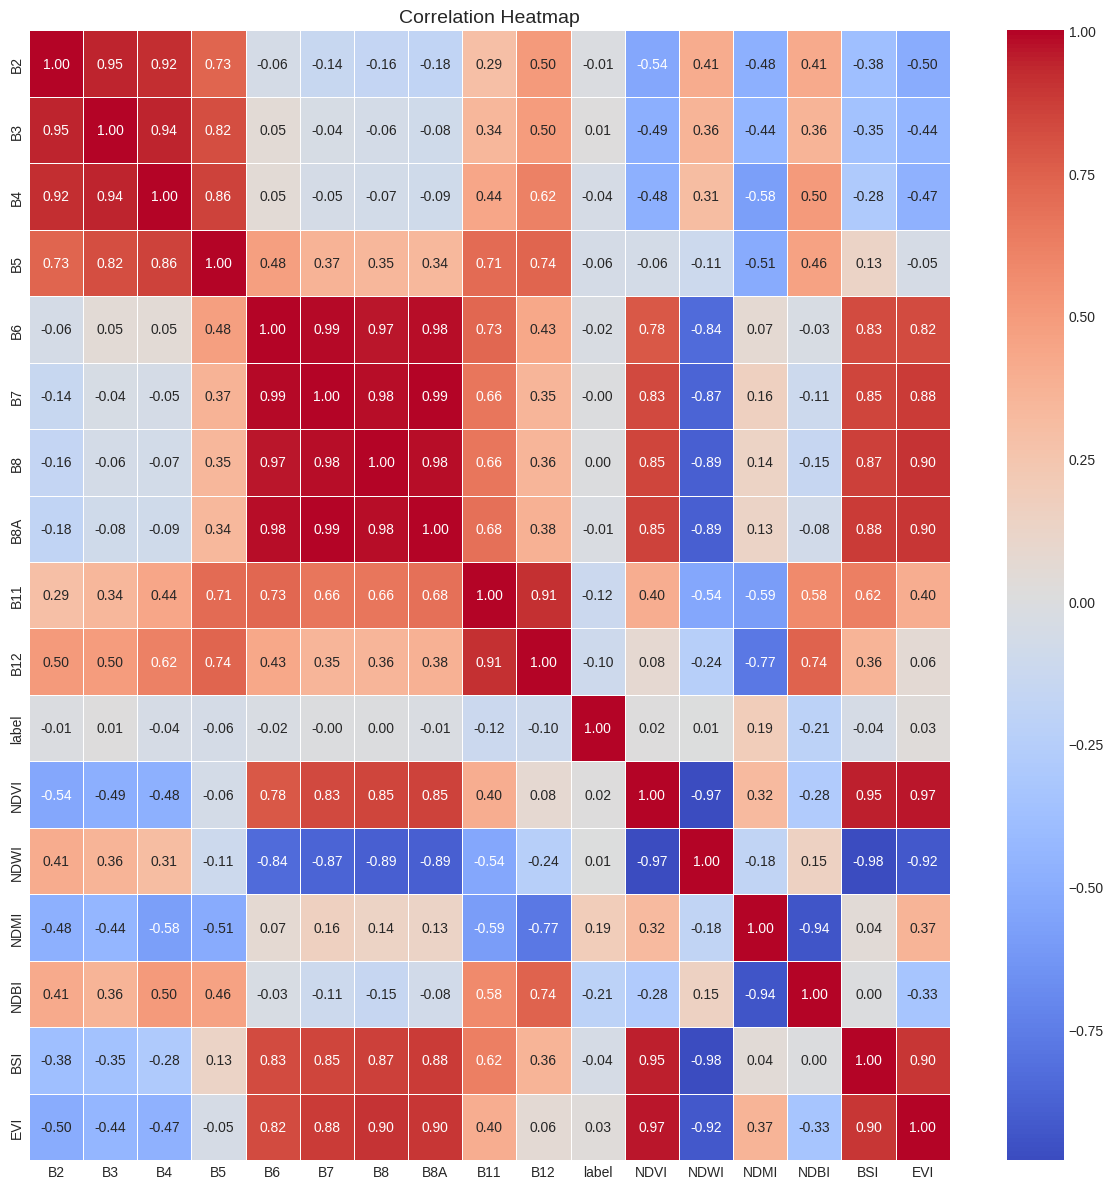

In [7]:
# Calculate correlation matrix
corr_matrix = train_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

columns_to_drop = ['B8']

# Kiểm tra xem các cột có tồn tại trong DataFrame trước khi xóa
existing_columns = [col for col in columns_to_drop if col in train_df.columns]

# Xóa các cột đó
train_df = train_df.drop(columns=existing_columns)


# Tìm Outlier dữ liệu

# Box plot

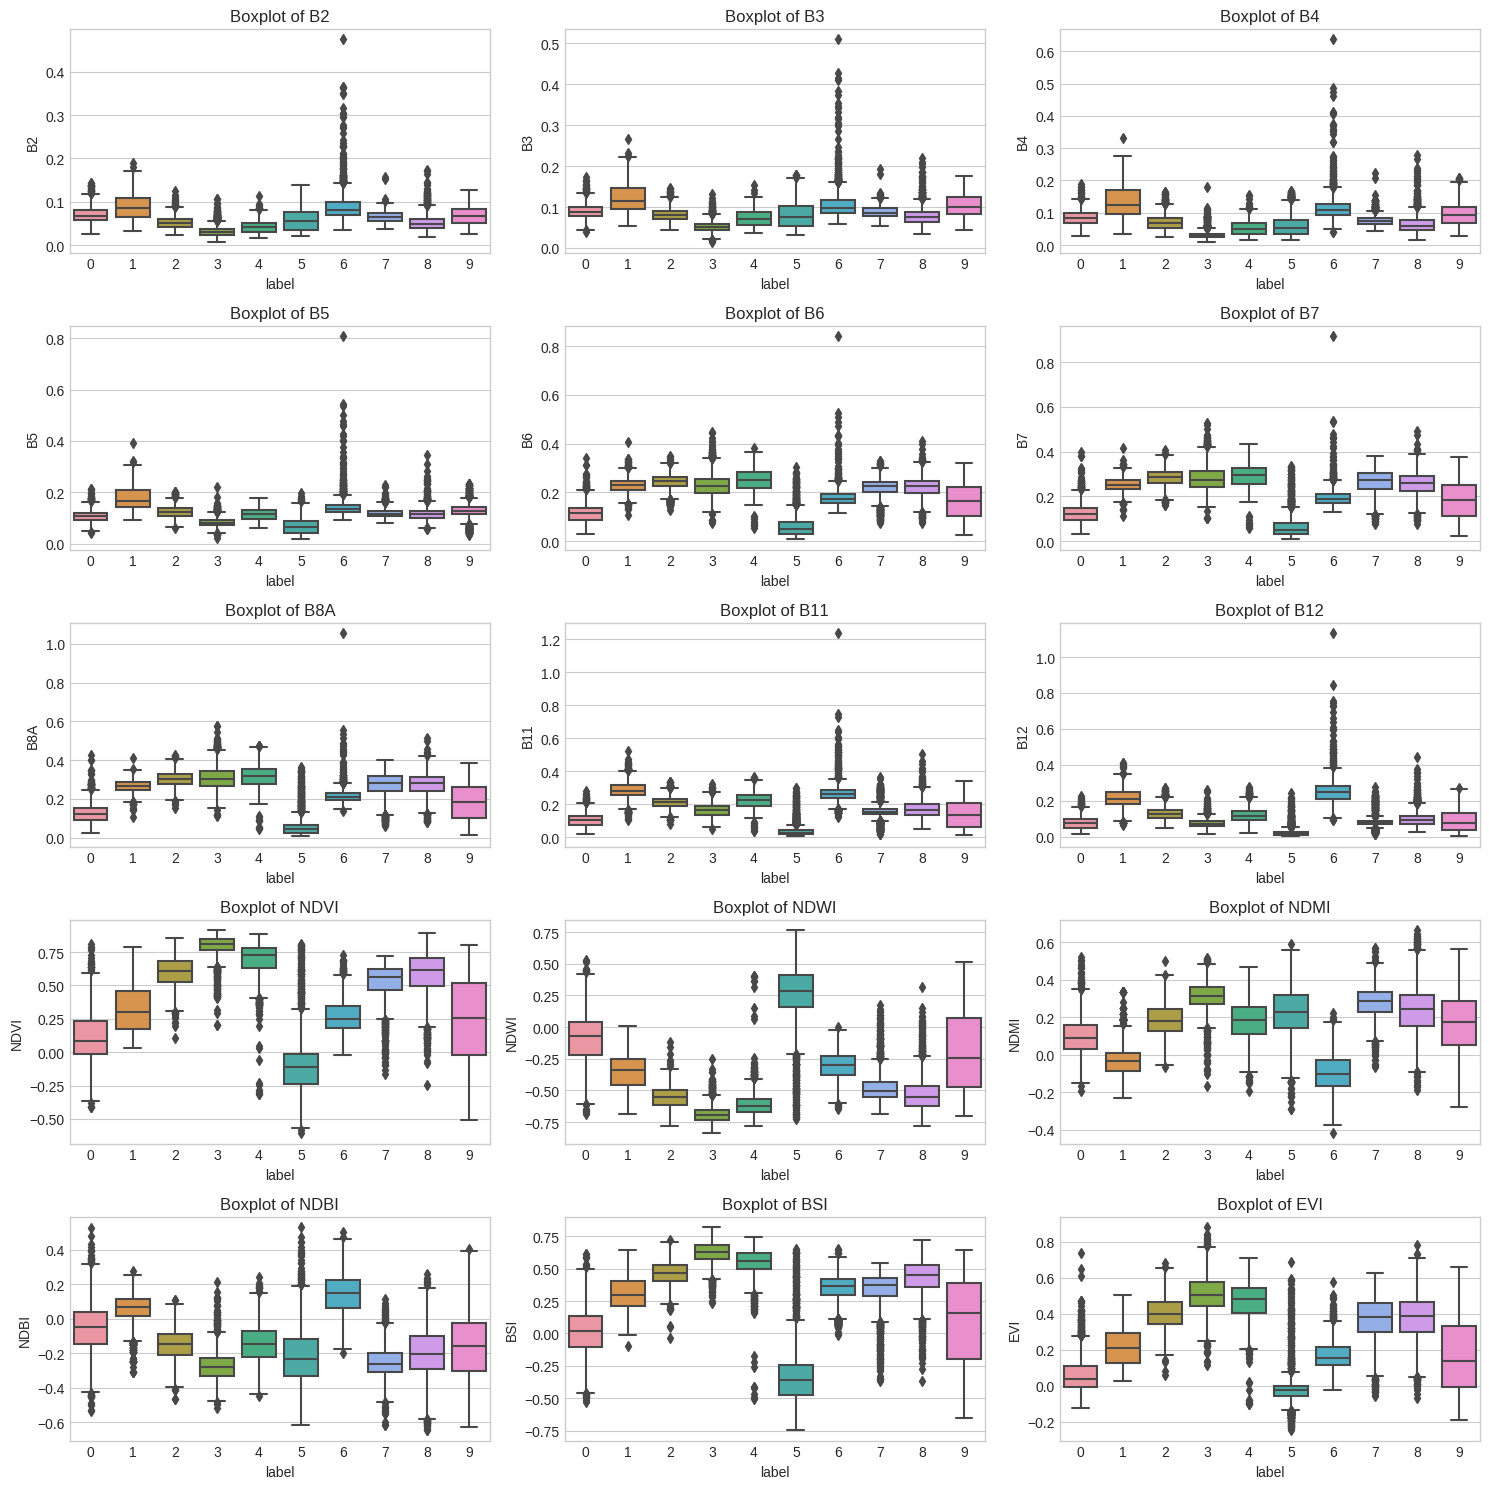

B2 - Outliers: 402 (Range: [-0.01, 0.13])
B3 - Outliers: 672 (Range: [0.02, 0.15])
B4 - Outliers: 592 (Range: [-0.02, 0.17])
B5 - Outliers: 930 (Range: [0.03, 0.20])
B6 - Outliers: 19 (Range: [0.01, 0.39])
B7 - Outliers: 12 (Range: [-0.02, 0.47])
B8A - Outliers: 12 (Range: [-0.02, 0.50])
B11 - Outliers: 52 (Range: [-0.06, 0.42])
B12 - Outliers: 398 (Range: [-0.07, 0.30])
NDVI - Outliers: 3 (Range: [-0.57, 1.40])
NDWI - Outliers: 711 (Range: [-1.17, 0.37])
NDMI - Outliers: 4 (Range: [-0.34, 0.66])
NDBI - Outliers: 19 (Range: [-0.67, 0.41])
BSI - Outliers: 1121 (Range: [-0.38, 1.03])
EVI - Outliers: 0 (Range: [-0.42, 0.96])


In [8]:
bands = np.array([col for col in train_df.columns if col != 'label'])

# Tính toán kích thước lưới linh hoạt
n_bands = len(bands)
n_cols = 3  # Số cột cố định
n_rows = math.ceil(n_bands / n_cols)  # Số hàng tự động tính dựa trên số band

# Vẽ biểu đồ hộp
plt.figure(figsize=(15, n_rows * 3))  # Điều chỉnh chiều cao dựa trên số hàng
for i, band in enumerate(bands, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='label', y=band, data=train_df)
    plt.xticks(rotation=0)
    plt.title(f'Boxplot of {band}')
plt.tight_layout()
plt.show()

# Hàm tính giá trị ngoại lai dựa trên IQR
def detect_outliers_iqr(train_df, column):
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_df[(train_df[column] < lower_bound) | (train_df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# In số lượng giá trị ngoại lai
for band in bands:
    outliers, lower, upper = detect_outliers_iqr(train_df, band)
    print(f"{band} - Outliers: {len(outliers)} (Range: [{lower:.2f}, {upper:.2f}])")


# Phân phối

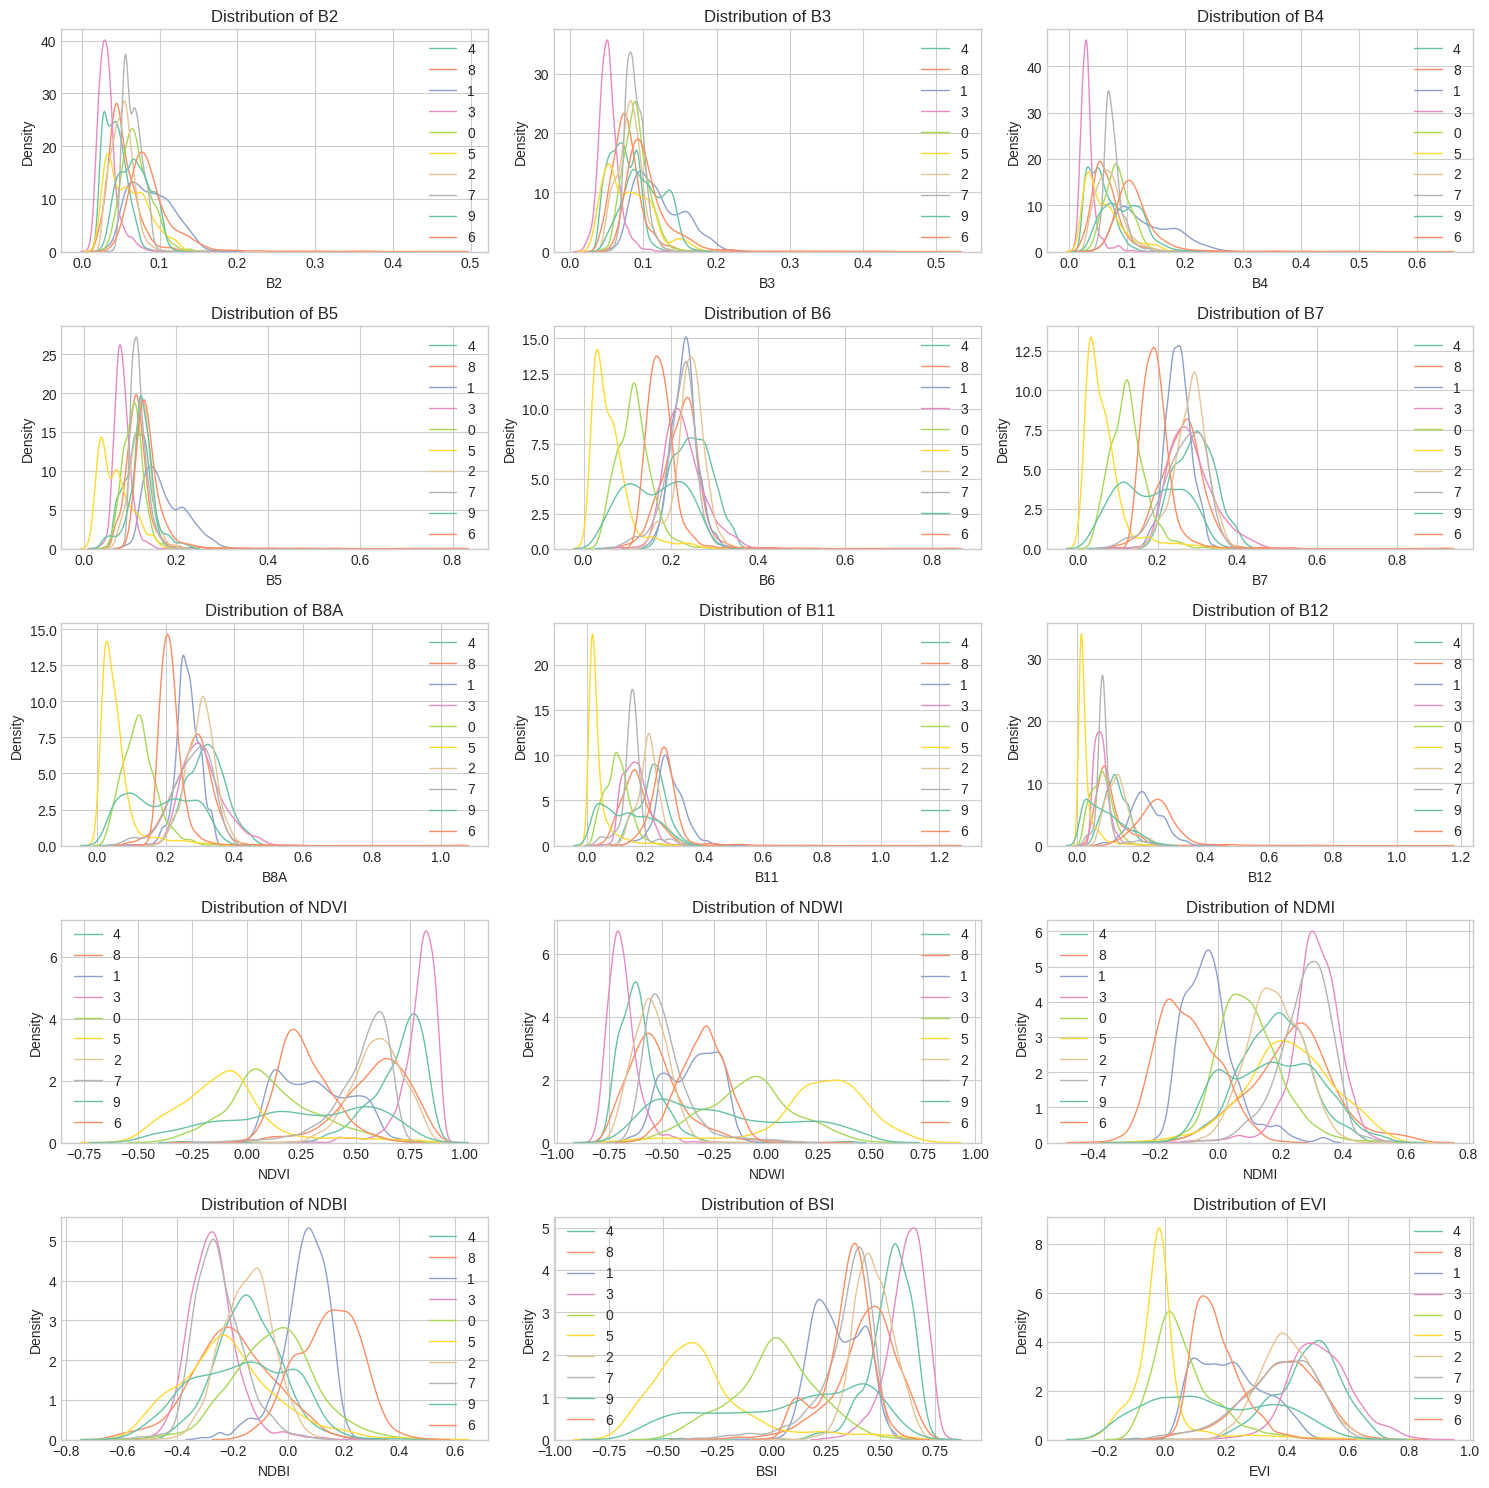

In [9]:
# Tắt warning FutureWarning từ seaborn
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Sao chép train_df và thay thế inf bằng NaN
bands = np.array([col for col in train_df.columns if col != 'label'])
labels = train_df['label'].unique()

# Thay thế inf bằng NaN trong toàn bộ dataframe
train_df = train_df.replace([np.inf, -np.inf], np.nan)

# Tính toán kích thước lưới linh hoạt
n_bands = len(bands)
n_cols = 3  # Số cột cố định
n_rows = math.ceil(n_bands / n_cols)  # Số hàng tự động dựa trên số band

# Vẽ biểu đồ phân phối
plt.figure(figsize=(15, n_rows * 3))  # Điều chỉnh chiều cao dựa trên số hàng
for i, band in enumerate(bands, 1):
    plt.subplot(n_rows, n_cols, i)
    for label in labels:
        subset = train_df[train_df['label'] == label][band].dropna()  # Loại bỏ NaN trước khi vẽ
        sns.kdeplot(subset, label=label, linewidth=1)
    plt.title(f'Distribution of {band}')
    plt.legend()
plt.tight_layout()
plt.show()


   feature  importance
8      B12    0.101374
11    NDMI    0.080140
7      B11    0.075171
6      B8A    0.071228
2       B4    0.069118
4       B6    0.068718
5       B7    0.067431
3       B5    0.065007
0       B2    0.062703
9     NDVI    0.062197
13     BSI    0.061625
12    NDBI    0.060807
10    NDWI    0.054626
1       B3    0.052963
14     EVI    0.046893


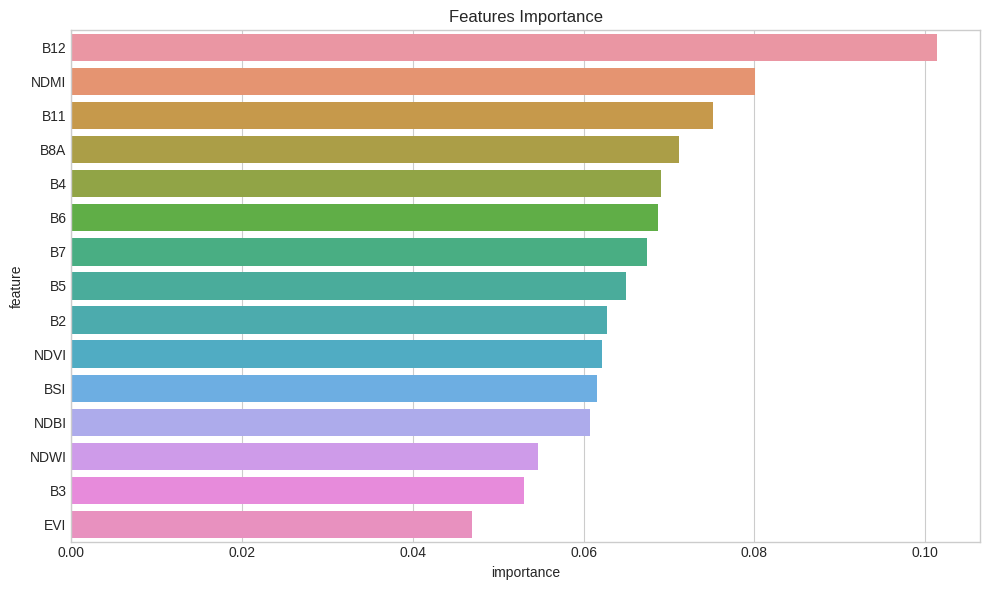

In [10]:
# Sử dụng Random Forest để đánh giá tầm quan trọng của đặc trưng
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Giả sử X là đặc trưng, y là biến mục tiêu
X = train_df.drop('label', axis=1)
y = train_df['label']

# Huấn luyện Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Hiển thị tầm quan trọng của đặc trưng
feature_importance = pd.DataFrame(
    {'feature': X.columns, 'importance': rf.feature_importances_}
).sort_values('importance', ascending=False)
print(feature_importance)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Features Importance')
plt.tight_layout()
plt.show()

columns_to_drop = ['EVI', 'B3']

# Kiểm tra xem các cột có tồn tại trong DataFrame trước khi xóa
existing_columns = [col for col in columns_to_drop if col in train_df.columns]

# Xóa các cột đó
train_df = train_df.drop(columns=existing_columns)